<a href="https://colab.research.google.com/github/mohsinposts/CS410-Project-YouTube-Controversy-Detector/blob/main/YouTube_Controversy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install youtube-comment-downloader
!pip install yt_dlp
!pip install transformers pandas matplotlib seaborn torch --quiet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from youtube_comment_downloader import YoutubeCommentDownloader, SORT_BY_POPULAR
from yt_dlp import YoutubeDL
from itertools import islice
import warnings
warnings.filterwarnings('ignore')

print("Loading sentiment analysis model...")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

LABELS = ["negative", "neutral", "positive"]

def get_recent_videos_from_channel(channel_url, max_videos=3):
    ydl_opts = {
        "quiet": True,
        "extract_flat": True,
        "skip_download": True,
        "no_warnings": True,
        "extractor_args": {"youtube": {"player_client": ["android"]}}
    }

    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(channel_url, download=False)

    entries = info.get("entries", [])
    if len(entries) > 0 and "entries" in entries[0]:
        entries = entries[0]["entries"]

    video_urls = [
        f"https://www.youtube.com/watch?v={video['id']}"
        for video in entries[:max_videos]
        if "id" in video
    ]

    return video_urls

def download_comments(video_url, limit=50):
    downloader = YoutubeCommentDownloader()
    comments = downloader.get_comments_from_url(video_url, sort_by=SORT_BY_POPULAR)
    limited_comments = list(islice(comments, limit))
    return limited_comments

def get_video_title(video_url):
    ydl_opts = {
        "quiet": True,
        "skip_download": True,
        "no_warnings": True,
        "extractor_args": {"youtube": {"player_client": ["android"]}}
    }

    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(video_url, download=False)

    return info.get("title", video_url)

def process_channels(channel_list, videos_per_channel=3, comment_limit=50):
    results = {}
    video_titles = {}
    channel_names = {}

    for channel in channel_list:
        channel_name = channel.split("@")[-1]
        print(f"\nProcessing channel: {channel}")

        video_urls = get_recent_videos_from_channel(channel, max_videos=videos_per_channel)
        print(f"  ➤ Found {len(video_urls)} videos")

        channel_data = {}

        for vid_url in video_urls:
            video_title = get_video_title(vid_url)
            video_titles[vid_url] = video_title
            channel_names[vid_url] = channel_name
            print(f"    ⤷ Downloading TOP comments for: {video_title}")
            comments = download_comments(vid_url, limit=comment_limit)
            channel_data[vid_url] = comments
            print(f"       → {len(comments)} top comments collected")

        results[channel] = channel_data

    return results, video_titles, channel_names

def analyze_sentiment(text):
    if not text or not isinstance(text, str):
        return "neutral", 0.0, 0.0

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)[0].detach().numpy()

    label_idx = np.argmax(probs)
    label = LABELS[label_idx]
    confidence = float(probs[label_idx])

    numeric = -1 if label == "negative" else 1 if label == "positive" else 0

    return label, confidence, numeric

def flatten_comment_data(raw):
    rows = []
    for channel, videos in raw.items():
        for video, comments in videos.items():
            for c in comments:
                rows.append({
                    "channel": channel,
                    "video": video,
                    "text": c.get("text", ""),
                    "likes": c.get("votes", 0),
                })
    return pd.DataFrame(rows)

def run_sentiment_pipeline(df):
    print(f"\nAnalyzing sentiment for {len(df)} comments...")
    sentiments = df["text"].apply(analyze_sentiment)
    df["sentiment_label"] = sentiments.apply(lambda x: x[0])
    df["sentiment_confidence"] = sentiments.apply(lambda x: x[1])
    df["sentiment_score"] = sentiments.apply(lambda x: x[2])
    print("Sentiment analysis complete!")
    return df

def categorize_video(row):
    controversy = row["controversy"]
    avg_sentiment = row["avg_sentiment"]

    if controversy < 0.3:
        if avg_sentiment > 0.5:
            return "Universally Positive"
        elif avg_sentiment < -0.5:
            return "Universally Negative"
        else:
            return "Neutral/Mild"
    else:
        return "Controversial/Mixed Opinions"

def compute_controversy(df, video_titles, channel_names):
    sentiment_breakdown = df.groupby(["video", "sentiment_label"]).size().unstack(fill_value=0)
    sentiment_breakdown = sentiment_breakdown.reset_index()

    for col in ["negative", "neutral", "positive"]:
        if col not in sentiment_breakdown.columns:
            sentiment_breakdown[col] = 0

    sentiment_breakdown["non_neutral"] = sentiment_breakdown["positive"] + sentiment_breakdown["negative"]

    sentiment_breakdown["controversy"] = sentiment_breakdown.apply(
        lambda row: (4 * row["positive"] * row["negative"] / (row["non_neutral"] ** 2))
        if row["non_neutral"] > 0 else 0,
        axis=1
    )

    avg_sentiment = df.groupby("video")["sentiment_score"].mean().reset_index()
    avg_sentiment.columns = ["video", "avg_sentiment"]

    grouped = sentiment_breakdown.merge(avg_sentiment, on="video", how="left")

    grouped["video_title"] = grouped["video"].map(video_titles)
    grouped["channel_name"] = grouped["video"].map(channel_names)
    grouped["count"] = grouped["positive"] + grouped["neutral"] + grouped["negative"]
    grouped["verdict"] = grouped.apply(categorize_video, axis=1)

    return grouped

def print_formatted_stats(stats):
    print("\n" + "="*100)
    print("VIDEO CONTROVERSY ANALYSIS")
    print("="*100)

    stats_sorted = stats.sort_values(["channel_name", "video_title"])

    current_channel = None
    for idx, row in stats_sorted.iterrows():
        if current_channel != row['channel_name']:
            if current_channel is not None:
                print()
            current_channel = row['channel_name']
            print(f"\n[{row['channel_name']}]")

        print(f"  → {row['video_title']}")
        print(f"    Controversy: {row['controversy']:.3f} | Avg Sentiment: {row['avg_sentiment']:.2f} | Verdict: {row['verdict']}")
        print(f"    Sentiment: Positive={row['positive']} | Neutral={row['neutral']} | Negative={row['negative']}")

    print("\n" + "="*100)

def plot_sentiment_breakdown_by_controversy(stats, top_n=10):
    top_videos = stats.nlargest(top_n, "controversy").copy()
    top_videos = top_videos.sort_values("controversy", ascending=True)
    top_videos["display_name"] = top_videos["channel_name"] + ": " + top_videos["video_title"].str[:50]

    total_comments = top_videos["positive"] + top_videos["neutral"] + top_videos["negative"]
    top_videos["neg_pct"] = (top_videos["negative"] / total_comments) * top_videos["controversy"]
    top_videos["neu_pct"] = (top_videos["neutral"] / total_comments) * top_videos["controversy"]
    top_videos["pos_pct"] = (top_videos["positive"] / total_comments) * top_videos["controversy"]

    fig, ax = plt.subplots(figsize=(14, 10))

    y_pos = range(len(top_videos))

    neg_bars = ax.barh(y_pos, top_videos["neg_pct"], color="#d62728", label="Negative", alpha=0.85)
    neu_bars = ax.barh(y_pos, top_videos["neu_pct"], left=top_videos["neg_pct"],
                       color="#7f7f7f", label="Neutral", alpha=0.85)
    pos_bars = ax.barh(y_pos, top_videos["pos_pct"],
                       left=top_videos["neg_pct"] + top_videos["neu_pct"],
                       color="#2ca02c", label="Positive", alpha=0.85)

    for i, (idx, row) in enumerate(top_videos.iterrows()):
        ax.text(row["controversy"] + 0.02, i,
                f"{row['controversy']:.3f}",
                va='center', fontsize=9, fontweight='bold')

        counts_text = f"({int(row['negative'])}/{int(row['neutral'])}/{int(row['positive'])})"
        ax.text(row["controversy"]/2, i, counts_text,
                va='center', ha='center', fontsize=8, color='white', fontweight='bold')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_videos["display_name"].values, fontsize=9)
    ax.set_xlabel("Controversy Score (0=Unanimous, 1=Maximum Disagreement)", fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1.1)
    ax.set_title(f"Top {top_n} Most Controversial Videos - Controversy Score with Sentiment Breakdown",
                 fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=11, title="Sentiment (as % of bar)")
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_channel_controversy_scatter(df, channel_names):
    video_stats = []
    for video in df["video"].unique():
        video_df = df[df["video"] == video]
        pos = (video_df["sentiment_label"] == "positive").sum()
        neg = (video_df["sentiment_label"] == "negative").sum()
        non_neutral = pos + neg

        if non_neutral > 0:
            controversy = 4 * pos * neg / (non_neutral ** 2)
        else:
            controversy = 0

        video_stats.append({
            "video": video,
            "channel": video_df["channel"].iloc[0],
            "controversy": controversy,
            "channel_name": channel_names[video]
        })

    video_controversy = pd.DataFrame(video_stats)

    fig, ax = plt.subplots(figsize=(12, 6))

    channels = sorted(video_controversy["channel_name"].unique())
    colors = plt.cm.Set3(range(len(channels)))

    for i, channel in enumerate(channels):
        channel_data = video_controversy[video_controversy["channel_name"] == channel]
        x_pos = [i] * len(channel_data)
        ax.scatter(x_pos, channel_data["controversy"], s=200, alpha=0.7,
                  color=colors[i], label=channel, edgecolors='black', linewidth=1.5)

    ax.set_xticks(range(len(channels)))
    ax.set_xticklabels(channels, rotation=45, ha="right", fontsize=11)
    ax.set_ylabel("Controversy Score (Pos/Neg Disagreement)", fontsize=12)
    ax.set_ylim(0, 1.1)
    ax.set_title("Video Controversy Distribution by Channel", fontsize=14, fontweight='bold')
    ax.grid(axis="y", alpha=0.3)
    ax.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_channel_std_deviation(df, channel_names):
    video_stats = []
    for video in df["video"].unique():
        video_df = df[df["video"] == video]
        pos = (video_df["sentiment_label"] == "positive").sum()
        neg = (video_df["sentiment_label"] == "negative").sum()
        non_neutral = pos + neg

        if non_neutral > 0:
            controversy = 4 * pos * neg / (non_neutral ** 2)
        else:
            controversy = 0

        video_stats.append({
            "video": video,
            "channel_name": channel_names[video],
            "controversy": controversy
        })

    video_controversy = pd.DataFrame(video_stats)

    channel_std = video_controversy.groupby("channel_name")["controversy"].std().reset_index()
    channel_std.columns = ["channel_name", "std_controversy"]
    channel_std = channel_std.sort_values("std_controversy", ascending=False)

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(channel_std["channel_name"], channel_std["std_controversy"],
                  color="steelblue", alpha=0.8, edgecolor='black', linewidth=1.5)

    for bar, val in zip(bars, channel_std["std_controversy"]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_xlabel("Channel", fontsize=12)
    ax.set_ylabel("Standard Deviation of Video Controversy", fontsize=12)
    ax.set_title("Consistency of Controversy Across Videos by Channel", fontsize=14, fontweight='bold')
    ax.set_xticklabels(channel_std["channel_name"], rotation=45, ha="right", fontsize=11)
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

def run_full_analysis(data, video_titles, channel_names):
    df = flatten_comment_data(data)
    print(f"\nFlattened {len(df)} comments from {df['video'].nunique()} videos")

    df = run_sentiment_pipeline(df)

    stats = compute_controversy(df, video_titles, channel_names)

    print_formatted_stats(stats)

    print("\nGenerating visualizations...")
    plot_sentiment_breakdown_by_controversy(stats)
    plot_channel_controversy_scatter(df, channel_names)
    plot_channel_std_deviation(df, channel_names)

    print("\nTop 3 most controversial videos:")
    top3 = stats.nlargest(3, "controversy")[["channel_name", "video_title", "controversy", "avg_sentiment", "verdict"]]
    for idx, row in top3.iterrows():
        print(f"\n  [{row['channel_name']}] {row['video_title']}")
        print(f"    Controversy: {row['controversy']:.3f} | Verdict: {row['verdict']}")

    return df, stats

Loading sentiment analysis model...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Processing channel: https://www.youtube.com/@SHNEAKO
  ➤ Found 3 videos
    ⤷ Downloading TOP comments for: SNEAKO X CASEY NEISTAT
       → 50 top comments collected
    ⤷ Downloading TOP comments for: DAVID LYNCH: FOLLOW YOUR DREAMS
       → 50 top comments collected
    ⤷ Downloading TOP comments for: NEVER KILL YOURSELF.
       → 50 top comments collected

Processing channel: https://www.youtube.com/@Clavicular0
  ➤ Found 3 videos
    ⤷ Downloading TOP comments for: Diamond gym is INSANE-(LY cringe)
       → 50 top comments collected
    ⤷ Downloading TOP comments for: Ultimate guide to getting BIGGER
       → 50 top comments collected
    ⤷ Downloading TOP comments for: How to SHRINK your NOSE at home
       → 50 top comments collected

Processing channel: https://www.youtube.com/@DannyMullenOfficial
  ➤ Found 3 videos
    ⤷ Downloading TOP comments for: TERRORIZING the Zohran Mamdani HQ
       → 50 top comments collected
    ⤷ Downloading TOP comments for: The Most INBRED Town in

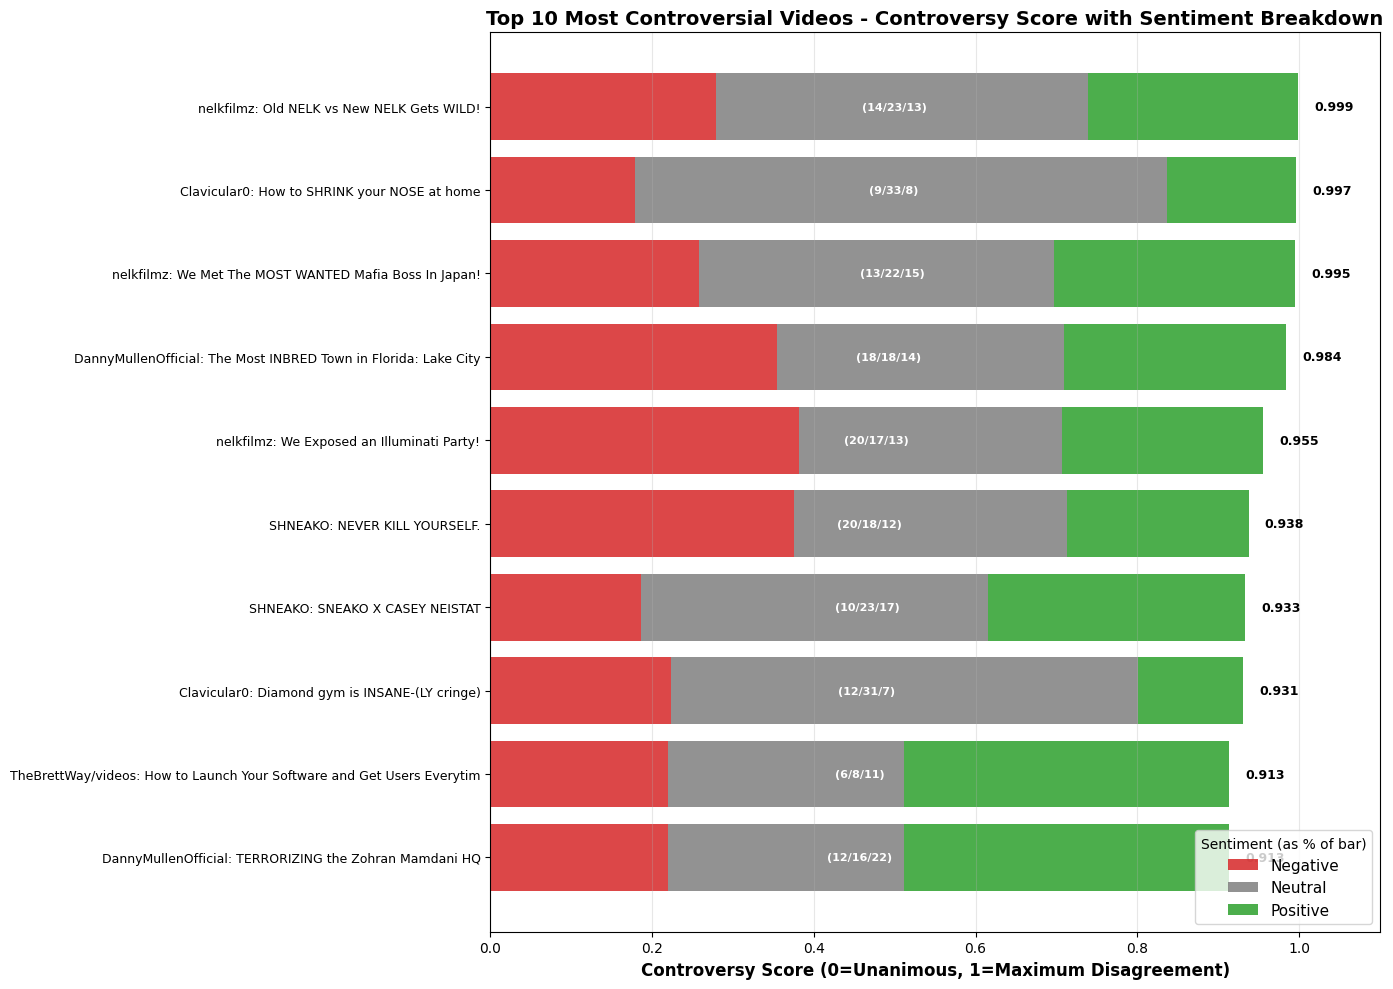

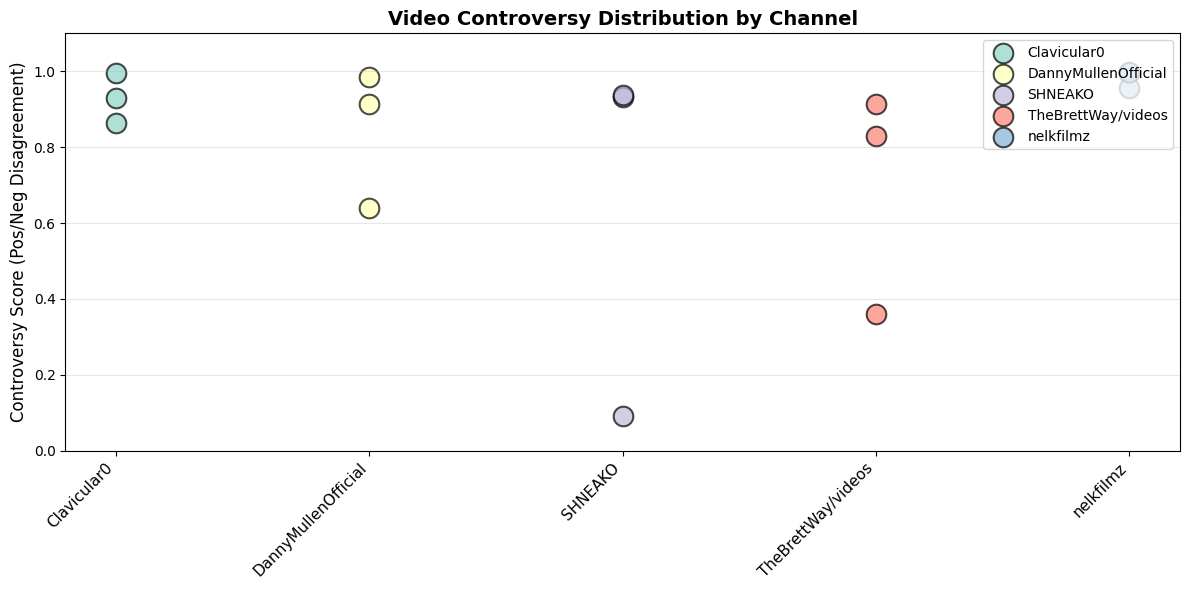

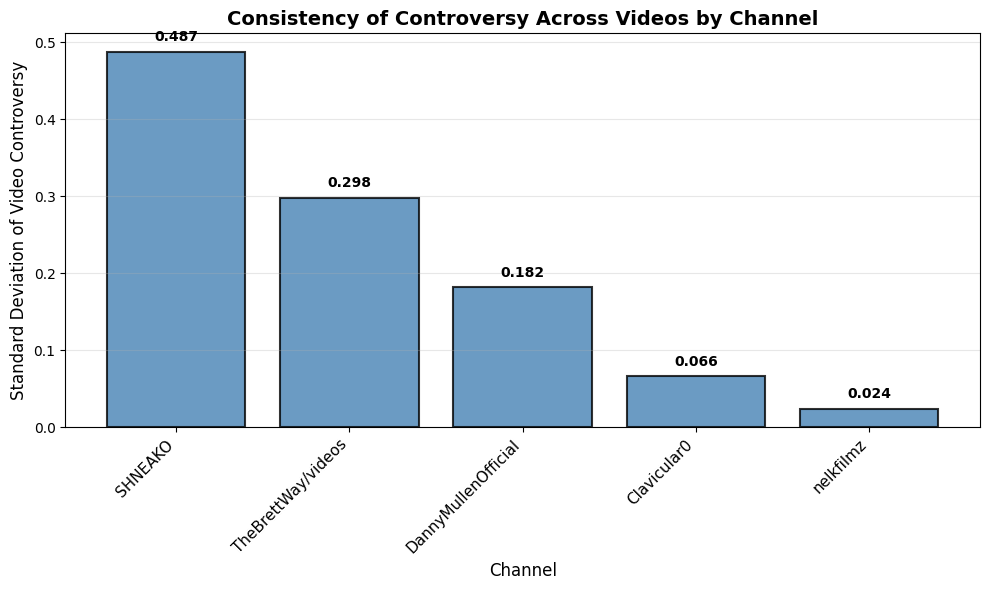


Top 3 most controversial videos:

  [nelkfilmz] Old NELK vs New NELK Gets WILD!
    Controversy: 0.999 | Verdict: Controversial/Mixed Opinions

  [Clavicular0] How to SHRINK your NOSE at home
    Controversy: 0.997 | Verdict: Controversial/Mixed Opinions

  [nelkfilmz] We Met The MOST WANTED Mafia Boss In Japan!
    Controversy: 0.995 | Verdict: Controversial/Mixed Opinions


In [ ]:
channels = [
    "https://www.youtube.com/@SHNEAKO",
    "https://www.youtube.com/@Clavicular0",
    "https://www.youtube.com/@DannyMullenOfficial",
    "https://www.youtube.com/@nelkfilmz",
    "https://www.youtube.com/@TheBrettWay/videos"
]

data, video_titles, channel_names = process_channels(channels, videos_per_channel=3, comment_limit=50)
df, stats = run_full_analysis(data, video_titles, channel_names)